# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 9

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.233
[2] loss: 0.135
[3] loss: 0.044
[4] loss: 0.026
[5] loss: 0.018
[6] loss: 0.013
[7] loss: 0.010
[8] loss: 0.009
[9] loss: 0.009
[10] loss: 0.006
[11] loss: 0.006
[12] loss: 0.005
[13] loss: 0.005
[14] loss: 0.003
[15] loss: 0.001
[16] loss: 0.007
[17] loss: 0.003
[18] loss: 0.003
[19] loss: 0.004
[20] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 9])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

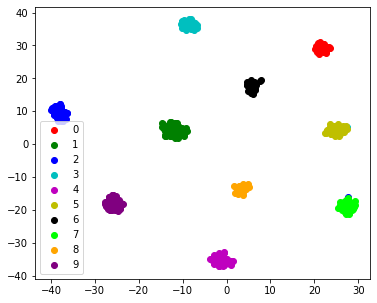

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

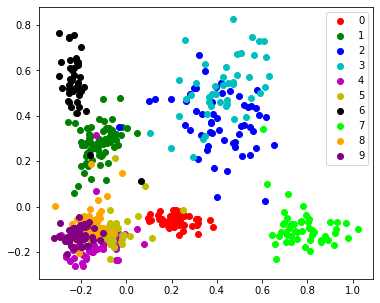

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.2031, -0.1235,  0.4026,  0.4340, -0.1638, -0.0715, -0.2262,  0.7674,
         -0.1672, -0.2132],
        [-0.2212, -0.1471,  0.3691, -0.3014,  0.3457, -0.2772, -0.1820, -0.2264,
          0.4577, -0.2041],
        [-0.0666,  0.2923,  0.3417,  0.5432, -0.1916, -0.0977,  0.5485, -0.1118,
         -0.0611, -0.1219],
        [ 0.3612, -0.2004,  0.2486,  0.2548, -0.2507, -0.2213, -0.1921, -0.2367,
         -0.0816,  0.3857],
        [-0.1987, -0.2233,  0.2494, -0.2396,  0.2057,  0.4363,  0.1690, -0.2520,
         -0.3077,  0.0445],
        [-0.1697,  0.4207, -0.3179,  0.4279, -0.2064,  0.4274, -0.1954, -0.2111,
          0.4176, -0.1640],
        [-0.1797,  0.2364, -0.3648,  0.4088, -0.2683,  0.5224, -0.1926, -0.2063,
          0.3673, -0.1619],
        [ 0.3983,  0.4113, -0.1714, -0.2174,  0.4733, -0.1517,  0.3037, -0.1748,
         -0.1385, -0.1636],
        [-0.1996,  0.4546, -0.1379, -0.1152,  0.2029, -0.1358, -0.1827,  0.4087,
         -0.1003,  0.5096]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_18.cfg')

['./config/sswae_dev2_1_18.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 3
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 9
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.403915e-01  D: 6.902828e-01  D2: 4.246901e-02  D3: 2.117145e-03
test loss: 1.808164e-01  D: 7.003878e-01  D2: 1.508812e-02  D3: 9.166608e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.754833e-01  D: 7.019335e-01  D2: 8.195796e-03  D3: 1.060835e-02
test loss: 1.606239e-01  D: 6.853522e-01  D2: 3.747625e-03  D3: 9.508472e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.505111e-01  D: 6.931242e-01  D2: 2.423878e-03  D3: 1.280827e-02
test loss: 1.280475e-01  D: 6.953012e-01  D2: 1.289349e-03  D3: 1.303927e-02


[default |INFO|model.py:1280] [04/80]  loss: 1.244721e-01  D: 6.953921e-01  D2: 2.603483e-04  D3: 1.349288e-02
test loss: 1.280785e-01  D: 6.925458e-01  D2: 1.047039e-04  D3: 1.616857e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.087767e-01  D: 6.917008e-01  D2: -1.807815e-03  D3: 1.367076e-02
test loss: 9.798889e-02  D: 7.118761e-01  D2: -2.889490e-03  D3: 1.211930e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.812254e-02  D: 6.958030e-01  D2: -2.706149e-03  D3: 1.335594e-02
test loss: 8.947189e-02  D: 7.250188e-01  D2: -3.344688e-03  D3: 1.492728e-02


[default |INFO|model.py:1280] [07/80]  loss: 8.922196e-02  D: 6.919408e-01  D2: -3.046741e-03  D3: 1.376536e-02
test loss: 8.446370e-02  D: 6.633697e-01  D2: -3.223038e-03  D3: 1.556331e-02


[default |INFO|model.py:1280] [08/80]  loss: 8.445044e-02  D: 6.930048e-01  D2: -3.772411e-03  D3: 1.369321e-02
test loss: 7.910739e-02  D: 6.995962e-01  D2: -4.404449e-03  D3: 1.326934e-02


[default |INFO|model.py:1280] [09/80]  loss: 7.898489e-02  D: 6.939624e-01  D2: -4.221282e-03  D3: 1.363922e-02
test loss: 7.567145e-02  D: 7.030054e-01  D2: -4.984083e-03  D3: 1.455217e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.485553e-02  D: 6.937454e-01  D2: -4.421711e-03  D3: 1.397969e-02
test loss: 7.235161e-02  D: 6.836896e-01  D2: -5.312929e-03  D3: 1.451529e-02


[default |INFO|model.py:1280] [11/80]  loss: 7.085698e-02  D: 6.932883e-01  D2: -4.893255e-03  D3: 1.415181e-02
test loss: 6.812928e-02  D: 7.070507e-01  D2: -5.392294e-03  D3: 1.477526e-02


[default |INFO|model.py:1280] [12/80]  loss: 6.898955e-02  D: 6.939151e-01  D2: -5.216505e-03  D3: 1.388414e-02
test loss: 6.842617e-02  D: 6.858552e-01  D2: -5.463753e-03  D3: 1.192341e-02


[default |INFO|model.py:1280] [13/80]  loss: 6.714637e-02  D: 6.934104e-01  D2: -5.208497e-03  D3: 1.396297e-02
test loss: 6.476089e-02  D: 6.801855e-01  D2: -6.050444e-03  D3: 1.372448e-02


[default |INFO|model.py:1280] [14/80]  loss: 6.594108e-02  D: 6.943279e-01  D2: -5.463529e-03  D3: 1.346869e-02
test loss: 6.445691e-02  D: 6.949091e-01  D2: -6.160259e-03  D3: 1.320723e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.453318e-02  D: 6.930897e-01  D2: -5.696112e-03  D3: 1.358166e-02
test loss: 6.523868e-02  D: 6.884244e-01  D2: -5.746050e-03  D3: 1.567800e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.240250e-02  D: 6.938857e-01  D2: -5.895778e-03  D3: 1.369643e-02
test loss: 6.277492e-02  D: 6.965005e-01  D2: -5.608349e-03  D3: 1.347476e-02


[default |INFO|model.py:1280] [17/80]  loss: 6.178487e-02  D: 6.933117e-01  D2: -6.095508e-03  D3: 1.360069e-02
test loss: 6.188701e-02  D: 6.945968e-01  D2: -6.484728e-03  D3: 1.153143e-02


[default |INFO|model.py:1280] [18/80]  loss: 6.025361e-02  D: 6.934033e-01  D2: -6.125051e-03  D3: 1.347941e-02
test loss: 6.116410e-02  D: 6.881912e-01  D2: -6.479483e-03  D3: 1.460914e-02


[default |INFO|model.py:1280] [19/80]  loss: 5.930093e-02  D: 6.935404e-01  D2: -6.118061e-03  D3: 1.363875e-02
test loss: 5.824651e-02  D: 6.916264e-01  D2: -6.036978e-03  D3: 1.323119e-02


[default |INFO|model.py:1280] [20/80]  loss: 5.827758e-02  D: 6.930850e-01  D2: -6.687605e-03  D3: 1.357721e-02
test loss: 5.806587e-02  D: 6.882974e-01  D2: -6.323624e-03  D3: 1.278417e-02


[default |INFO|model.py:1280] [21/80]  loss: 5.808737e-02  D: 6.929955e-01  D2: -6.764661e-03  D3: 1.325203e-02
test loss: 5.782465e-02  D: 7.074338e-01  D2: -7.059355e-03  D3: 1.459228e-02


[default |INFO|model.py:1280] [22/80]  loss: 5.858400e-02  D: 6.939130e-01  D2: -6.692416e-03  D3: 1.312586e-02
test loss: 5.880126e-02  D: 6.853117e-01  D2: -5.865507e-03  D3: 1.348154e-02


[default |INFO|model.py:1280] [23/80]  loss: 5.790888e-02  D: 6.936188e-01  D2: -6.786288e-03  D3: 1.308921e-02
test loss: 5.759870e-02  D: 6.885764e-01  D2: -6.859140e-03  D3: 1.263011e-02


[default |INFO|model.py:1280] [24/80]  loss: 5.773997e-02  D: 6.936952e-01  D2: -6.970515e-03  D3: 1.290302e-02
test loss: 5.917030e-02  D: 6.849151e-01  D2: -7.252789e-03  D3: 1.388270e-02


[default |INFO|model.py:1280] [25/80]  loss: 5.640493e-02  D: 6.930309e-01  D2: -7.116262e-03  D3: 1.292634e-02
test loss: 5.727726e-02  D: 7.059049e-01  D2: -7.387495e-03  D3: 1.417063e-02


[default |INFO|model.py:1280] [26/80]  loss: 5.651230e-02  D: 6.933971e-01  D2: -7.083817e-03  D3: 1.276008e-02
test loss: 5.596719e-02  D: 6.956534e-01  D2: -7.233496e-03  D3: 1.304906e-02


[default |INFO|model.py:1280] [27/80]  loss: 5.593057e-02  D: 6.930485e-01  D2: -7.316297e-03  D3: 1.272836e-02
test loss: 5.670531e-02  D: 6.954940e-01  D2: -7.047720e-03  D3: 1.189640e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.677654e-02  D: 6.931368e-01  D2: -7.282095e-03  D3: 1.270528e-02
test loss: 5.576767e-02  D: 6.925833e-01  D2: -7.781610e-03  D3: 1.192210e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.542152e-02  D: 6.936982e-01  D2: -7.585979e-03  D3: 1.262797e-02
test loss: 5.443497e-02  D: 6.947456e-01  D2: -7.674561e-03  D3: 1.307230e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.499895e-02  D: 6.933155e-01  D2: -7.604259e-03  D3: 1.252765e-02
test loss: 5.404116e-02  D: 6.945767e-01  D2: -7.985716e-03  D3: 1.288376e-02


[default |INFO|model.py:1280] [31/80]  loss: 5.523609e-02  D: 6.932252e-01  D2: -7.570761e-03  D3: 1.243369e-02
test loss: 5.406549e-02  D: 6.985236e-01  D2: -7.881823e-03  D3: 1.317302e-02


[default |INFO|model.py:1280] [32/80]  loss: 5.446108e-02  D: 6.936237e-01  D2: -7.769891e-03  D3: 1.249119e-02
test loss: 5.549174e-02  D: 6.964723e-01  D2: -8.131895e-03  D3: 1.372823e-02


[default |INFO|model.py:1280] [33/80]  loss: 5.483407e-02  D: 6.933932e-01  D2: -7.780431e-03  D3: 1.236296e-02
test loss: 5.613054e-02  D: 6.908172e-01  D2: -7.693596e-03  D3: 1.313219e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.465011e-02  D: 6.934501e-01  D2: -7.916757e-03  D3: 1.232269e-02
test loss: 5.486597e-02  D: 6.840811e-01  D2: -8.203058e-03  D3: 1.272841e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.413995e-02  D: 6.931917e-01  D2: -7.993345e-03  D3: 1.233529e-02
test loss: 5.433604e-02  D: 6.997465e-01  D2: -8.067560e-03  D3: 1.288504e-02


[default |INFO|model.py:1280] [36/80]  loss: 5.484756e-02  D: 6.935926e-01  D2: -7.993792e-03  D3: 1.200266e-02
test loss: 5.391335e-02  D: 6.934893e-01  D2: -8.316145e-03  D3: 1.227557e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.522185e-02  D: 6.935678e-01  D2: -8.010778e-03  D3: 1.225614e-02
test loss: 5.335385e-02  D: 7.137851e-01  D2: -8.137226e-03  D3: 1.346030e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.298628e-02  D: 6.936351e-01  D2: -8.112187e-03  D3: 1.236095e-02
test loss: 5.445835e-02  D: 6.907314e-01  D2: -8.368750e-03  D3: 1.360178e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.268941e-02  D: 6.934581e-01  D2: -8.199296e-03  D3: 1.244892e-02
test loss: 5.434568e-02  D: 6.891969e-01  D2: -8.504190e-03  D3: 1.174711e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.220127e-02  D: 6.932415e-01  D2: -8.378483e-03  D3: 1.235596e-02
test loss: 5.259357e-02  D: 6.976890e-01  D2: -8.352051e-03  D3: 1.235082e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.210204e-02  D: 6.930875e-01  D2: -8.435141e-03  D3: 1.235796e-02
test loss: 5.308862e-02  D: 6.965373e-01  D2: -8.268328e-03  D3: 1.212686e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.200728e-02  D: 6.933999e-01  D2: -8.346095e-03  D3: 1.226334e-02
test loss: 5.324573e-02  D: 6.985933e-01  D2: -8.436375e-03  D3: 1.362603e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.209873e-02  D: 6.933186e-01  D2: -8.506729e-03  D3: 1.219762e-02
test loss: 5.406899e-02  D: 7.017175e-01  D2: -8.313513e-03  D3: 1.262844e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.225139e-02  D: 6.931668e-01  D2: -8.512508e-03  D3: 1.218831e-02
test loss: 5.509854e-02  D: 6.866599e-01  D2: -8.596010e-03  D3: 1.114126e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.265356e-02  D: 6.932245e-01  D2: -8.515099e-03  D3: 1.184898e-02
test loss: 5.476237e-02  D: 6.974646e-01  D2: -8.165207e-03  D3: 1.389737e-02


[default |INFO|model.py:1280] [46/80]  loss: 5.191770e-02  D: 6.933699e-01  D2: -8.621806e-03  D3: 1.217252e-02
test loss: 5.474508e-02  D: 7.027420e-01  D2: -8.474941e-03  D3: 1.347256e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.145061e-02  D: 6.930324e-01  D2: -8.654504e-03  D3: 1.207958e-02
test loss: 5.260769e-02  D: 6.959739e-01  D2: -8.917475e-03  D3: 1.291416e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.147647e-02  D: 6.936706e-01  D2: -8.621500e-03  D3: 1.202792e-02
test loss: 5.392581e-02  D: 6.902541e-01  D2: -8.544979e-03  D3: 1.034721e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.266682e-02  D: 6.934314e-01  D2: -8.615913e-03  D3: 1.169213e-02
test loss: 5.667423e-02  D: 6.905561e-01  D2: -8.754358e-03  D3: 8.813057e-03


[default |INFO|model.py:1280] [50/80]  loss: 5.330718e-02  D: 6.932294e-01  D2: -8.760529e-03  D3: 1.139279e-02
test loss: 5.346954e-02  D: 6.893999e-01  D2: -8.860130e-03  D3: 1.287510e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.090037e-02  D: 6.932956e-01  D2: -8.703904e-03  D3: 1.207100e-02
test loss: 5.337155e-02  D: 6.926472e-01  D2: -8.813143e-03  D3: 1.112332e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.089304e-02  D: 6.932547e-01  D2: -9.015725e-03  D3: 1.192260e-02
test loss: 5.173036e-02  D: 6.929364e-01  D2: -8.843279e-03  D3: 1.263501e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.083306e-02  D: 6.931124e-01  D2: -8.785699e-03  D3: 1.201532e-02
test loss: 5.307105e-02  D: 6.940622e-01  D2: -8.629036e-03  D3: 1.282973e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.088160e-02  D: 6.931918e-01  D2: -8.879598e-03  D3: 1.200486e-02
test loss: 5.366275e-02  D: 6.859757e-01  D2: -8.147335e-03  D3: 1.134792e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.031504e-02  D: 6.930839e-01  D2: -8.986715e-03  D3: 1.183802e-02
test loss: 5.183249e-02  D: 6.967526e-01  D2: -8.714275e-03  D3: 1.223074e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.024105e-02  D: 6.933289e-01  D2: -8.961574e-03  D3: 1.192214e-02
test loss: 5.302198e-02  D: 6.941792e-01  D2: -9.185743e-03  D3: 1.143049e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.035358e-02  D: 6.931809e-01  D2: -8.999734e-03  D3: 1.190924e-02
test loss: 5.321294e-02  D: 6.960610e-01  D2: -9.095984e-03  D3: 1.261462e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.029781e-02  D: 6.933259e-01  D2: -8.992953e-03  D3: 1.175438e-02
test loss: 5.319492e-02  D: 6.947450e-01  D2: -9.056463e-03  D3: 1.238435e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.062755e-02  D: 6.932093e-01  D2: -9.052118e-03  D3: 1.185914e-02
test loss: 5.174229e-02  D: 6.906577e-01  D2: -9.193487e-03  D3: 1.088855e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.026989e-02  D: 6.932737e-01  D2: -9.064539e-03  D3: 1.169713e-02
test loss: 5.231658e-02  D: 6.935756e-01  D2: -9.234190e-03  D3: 1.294146e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.035706e-02  D: 6.931248e-01  D2: -9.231345e-03  D3: 1.162721e-02
test loss: 5.222169e-02  D: 6.977289e-01  D2: -9.202900e-03  D3: 1.280814e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.016691e-02  D: 6.933540e-01  D2: -9.132291e-03  D3: 1.168985e-02
test loss: 5.145465e-02  D: 6.952613e-01  D2: -9.315414e-03  D3: 1.184280e-02


[default |INFO|model.py:1280] [63/80]  loss: 4.984170e-02  D: 6.933876e-01  D2: -9.267025e-03  D3: 1.160563e-02
test loss: 5.093814e-02  D: 6.967378e-01  D2: -9.258680e-03  D3: 1.245530e-02


[default |INFO|model.py:1280] [64/80]  loss: 4.982317e-02  D: 6.931639e-01  D2: -9.197117e-03  D3: 1.169670e-02
test loss: 5.215991e-02  D: 6.894953e-01  D2: -9.613972e-03  D3: 1.094338e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.944733e-02  D: 6.931435e-01  D2: -9.248204e-03  D3: 1.160545e-02
test loss: 5.246964e-02  D: 6.983235e-01  D2: -8.832111e-03  D3: 1.165182e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.947325e-02  D: 6.932247e-01  D2: -9.345018e-03  D3: 1.151145e-02
test loss: 5.316031e-02  D: 6.894551e-01  D2: -9.377165e-03  D3: 1.108032e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.974218e-02  D: 6.931243e-01  D2: -9.394348e-03  D3: 1.145499e-02
test loss: 5.262023e-02  D: 6.860275e-01  D2: -9.291363e-03  D3: 1.034568e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.002184e-02  D: 6.935542e-01  D2: -9.320111e-03  D3: 1.141296e-02
test loss: 5.275885e-02  D: 6.888937e-01  D2: -9.112978e-03  D3: 1.192021e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.936187e-02  D: 6.932216e-01  D2: -9.460257e-03  D3: 1.157525e-02
test loss: 5.183629e-02  D: 6.943342e-01  D2: -9.189243e-03  D3: 1.134204e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.929580e-02  D: 6.931554e-01  D2: -9.413273e-03  D3: 1.159564e-02
test loss: 5.285681e-02  D: 6.944853e-01  D2: -9.335241e-03  D3: 1.123300e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.942235e-02  D: 6.931879e-01  D2: -9.497204e-03  D3: 1.136276e-02
test loss: 5.239557e-02  D: 6.972237e-01  D2: -9.162197e-03  D3: 1.160346e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.919609e-02  D: 6.932851e-01  D2: -9.526447e-03  D3: 1.138626e-02
test loss: 5.272639e-02  D: 6.973987e-01  D2: -9.747553e-03  D3: 1.069095e-02


[default |INFO|model.py:1280] [73/80]  loss: 4.944452e-02  D: 6.932369e-01  D2: -9.460764e-03  D3: 1.151370e-02
test loss: 5.170848e-02  D: 7.068564e-01  D2: -9.416838e-03  D3: 1.132715e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.958795e-02  D: 6.931360e-01  D2: -9.493251e-03  D3: 1.130874e-02
test loss: 5.116396e-02  D: 6.959847e-01  D2: -9.219818e-03  D3: 1.166587e-02


[default |INFO|model.py:1280] [75/80]  loss: 4.903741e-02  D: 6.932496e-01  D2: -9.563309e-03  D3: 1.132516e-02
test loss: 5.095285e-02  D: 6.929633e-01  D2: -9.527035e-03  D3: 1.163062e-02


[default |INFO|model.py:1280] [76/80]  loss: 4.903966e-02  D: 6.932506e-01  D2: -9.572991e-03  D3: 1.134718e-02
test loss: 5.069395e-02  D: 6.977931e-01  D2: -9.668264e-03  D3: 1.157443e-02


[default |INFO|model.py:1280] [77/80]  loss: 4.853954e-02  D: 6.932382e-01  D2: -9.657024e-03  D3: 1.133041e-02
test loss: 5.015151e-02  D: 6.942942e-01  D2: -9.775286e-03  D3: 1.106568e-02


[default |INFO|model.py:1280] [78/80]  loss: 4.846049e-02  D: 6.931011e-01  D2: -9.636591e-03  D3: 1.133522e-02
test loss: 5.091022e-02  D: 6.939142e-01  D2: -9.576101e-03  D3: 1.102643e-02


[default |INFO|model.py:1280] [79/80]  loss: 4.838203e-02  D: 6.932848e-01  D2: -9.590829e-03  D3: 1.132831e-02
test loss: 5.048297e-02  D: 6.996320e-01  D2: -8.942337e-03  D3: 1.207328e-02


[default |INFO|model.py:1280] [80/80]  loss: 4.838438e-02  D: 6.931556e-01  D2: -9.689608e-03  D3: 1.127502e-02
test loss: 5.182886e-02  D: 6.920188e-01  D2: -9.625969e-03  D3: 1.120300e-02
[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3584.251s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

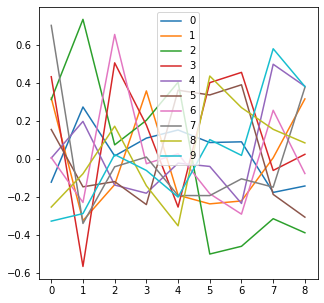

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

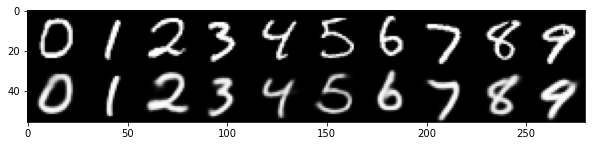

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

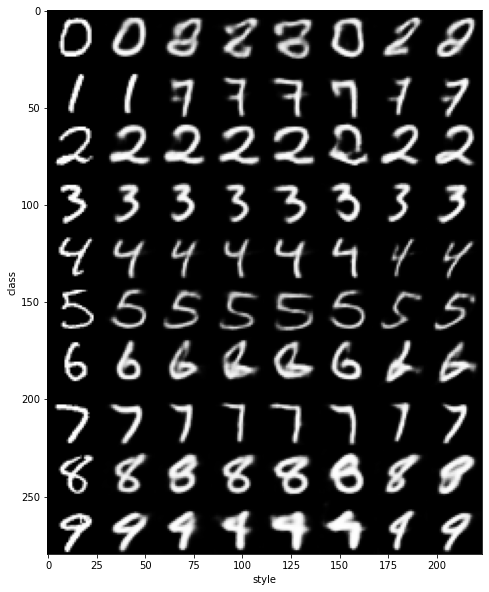

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

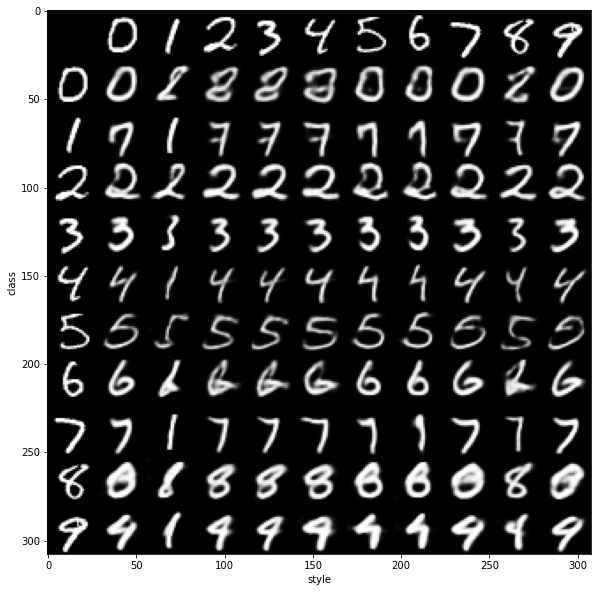

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()